In [3]:
import torch
import torchaudio
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nnAudio.features import MFCC

In [19]:
def extract_mfcc_transformer(sample_rate, n_mfcc=40):
    """
    创建并返回MFCC变换对象。
    
    MFCC（Mel-frequency Cepstral Coefficients）是在梅尔频谱基础上
    通过离散余弦变换（DCT）得到的倒谱系数，广泛用于语音识别和音频分析。
    MFCC能够有效地表示音频信号的频谱包络特征。
    
    Args:
        sample_rate (int): 音频采样率，决定了频谱分析的频率范围
        n_mfcc (int): MFCC系数的数量，通常取12-13个
    
    Returns:
        Spectrogram.MFCC: 初始化完成的MFCC对象
        
    参数说明:
        - sr: 采样率
        - n_mfcc: MFCC系数数量，决定输出特征维度
        - n_fft: FFT窗口大小，影响频率分辨率
        - n_mels: 中间梅尔滤波器组数量
        - hop_length: 帧移，控制时间分辨率
        - window: 窗函数类型，'hamming'提供良好的频率泄漏控制
        - center: 是否对信号进行中心填充
        - pad_mode: 填充模式，'reflect'进行镜像填充
        - power: 功率谱指数，2.0表示功率谱
        - htk: 是否使用HTK Mel刻度公式
        - fmin/fmax: 频率范围限制
        - norm: 归一化方式
        - trainable_mel/trainable_STFT: 是否允许训练过程中调整参数
    """
    # 初始化MFCC变换对象
    mfcc_transformer = MFCC(
        sr=sample_rate,
        n_mfcc=n_mfcc,
        n_fft=2048,
        n_mels=128,
        hop_length=512,
        window='hamming',
        center=True,
        pad_mode='reflect',
        power=2.0,
        htk=False,
        fmin=0,
        fmax=None,
        norm=1,
        trainable_mel=False,
        trainable_STFT=False,
        verbose=False
    )
    return mfcc_transformer

In [5]:
def extract_mfcc_with_delta(waveform, sample_rate, n_mfcc=13, feature_type='mfcc', include_delta=True, include_delta2=True):
    """
    提取MFCC特征及其一阶、二阶差分特征
    
    Args:
        waveform (torch.Tensor): 输入音频波形数据
        sample_rate (int): 采样率
        n_mfcc (int): MFCC系数数量
        feature_type (str): 返回的特征类型
            - 'mfcc': 仅返回基础MFCC特征
            - 'delta': 仅返回一阶差分特征
            - 'delta2': 仅返回二阶差分特征
            - 'combined': 返回组合特征（根据include_delta和include_delta2参数）
        include_delta (bool): 当feature_type='combined'时，是否包含一阶差分
        include_delta2 (bool): 当feature_type='combined'时，是否包含二阶差分
    
    Returns:
        numpy.ndarray: 指定类型的MFCC特征
    """
    # 基础MFCC变换器
    mfcc_transformer = extract_mfcc_transformer(sample_rate, n_mfcc)
    
    # 提取基础MFCC特征
    mfcc_features = mfcc_transformer(waveform)
    mfcc_data = mfcc_features.detach().cpu().numpy()[0]
    
    if feature_type == 'mfcc':
        return mfcc_data
    elif feature_type == 'delta':
        # 返回一阶差分特征
        delta_mfcc = librosa.feature.delta(mfcc_data)
        plot_mfcc_features(delta_mfcc, sample_rate, f'mfcc_features_{feature_type}.png')
        return delta_mfcc
    elif feature_type == 'delta2':
        # 返回二阶差分特征
        delta2_mfcc = librosa.feature.delta(mfcc_data, order=2)
        plot_mfcc_features(delta2_mfcc, sample_rate, f'mfcc_features_{feature_type}.png')
        return delta2_mfcc
    elif feature_type == 'combined':
        # 返回组合特征
        features_list = [mfcc_data]
        
        if include_delta:
            # 计算一阶差分
            delta_mfcc = librosa.feature.delta(mfcc_data)
            features_list.append(delta_mfcc)
        
        if include_delta2:
            # 计算二阶差分
            delta2_mfcc = librosa.feature.delta(mfcc_data, order=2)
            features_list.append(delta2_mfcc)
        
        # 拼接所有特征
        combined_features = np.stack(features_list, axis=0)
        return combined_features

In [6]:
def save_mfcc_to_csv(mfcc_features, output_csv):
    """
    将MFCC特征保存为CSV文件
    :param mfcc_features: MFCC特征矩阵
    :param output_csv: CSV文件路径
    """
    df = pd.DataFrame(mfcc_features)
    df.to_csv(output_csv, index=False, header=False)
    print(f"MFCC特征已保存至 {output_csv}")

In [11]:
def plot_mfcc_features(mfcc_data, sr, output_image=None):
    """
    可视化MFCC特征
    :param mfcc_data: MFCC特征矩阵
    :param sr: 采样率
    :param output_image: 如果提供路径，则保存图片
    """
    plt.figure(figsize=(12, 8))

    librosa.display.specshow(mfcc_data, sr=sr, hop_length=512, x_axis='time', y_axis='linear', cmap='viridis')
    plt.title("MFCC Features")
    plt.xlabel("Time(s)")
    plt.ylabel("MFCC Coefficients")
    plt.tight_layout()

    if output_image:
        plt.savefig(output_image)
        print(f"MFCC特征图已保存至 {output_image}")
    else:
        plt.show()

MFCC特征已保存至 mfcc_features.csv
MFCC特征图已保存至 mfcc_features.png
MFCC特征图已保存至 mfcc_features_delta.png
MFCC特征图已保存至 mfcc_features_delta2.png


array([[ 2.149902  ,  2.149902  ,  2.149902  , ...,  2.110679  ,
         2.110679  ,  2.110679  ],
       [ 0.9326673 ,  0.9326673 ,  0.9326673 , ...,  0.71824133,
         0.71824133,  0.71824133],
       [-0.42167148, -0.42167148, -0.42167148, ..., -0.1426305 ,
        -0.1426305 , -0.1426305 ],
       ...,
       [-0.34236333, -0.34236333, -0.34236333, ..., -0.60613585,
        -0.60613585, -0.60613585],
       [ 0.09180743,  0.09180743,  0.09180743, ..., -0.47959104,
        -0.47959104, -0.47959104],
       [ 0.08674611,  0.08674611,  0.08674611, ...,  0.44049412,
         0.44049412,  0.44049412]], dtype=float32)

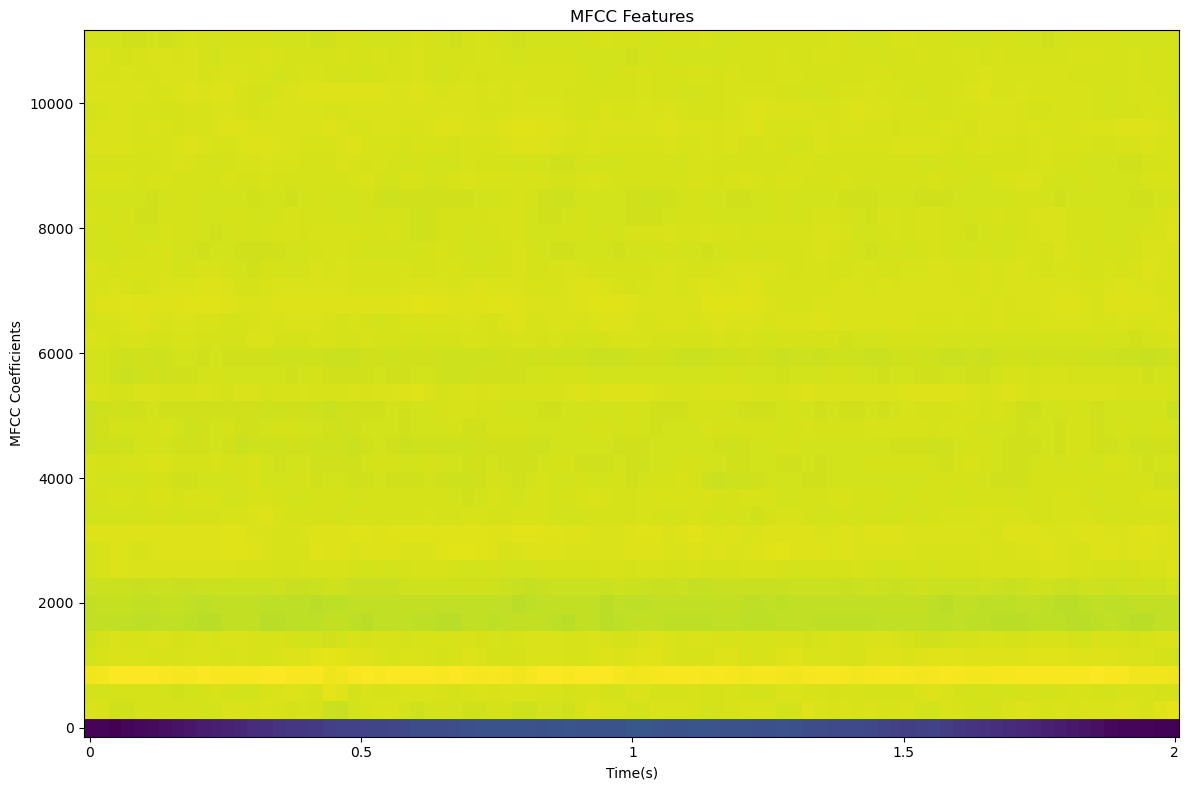

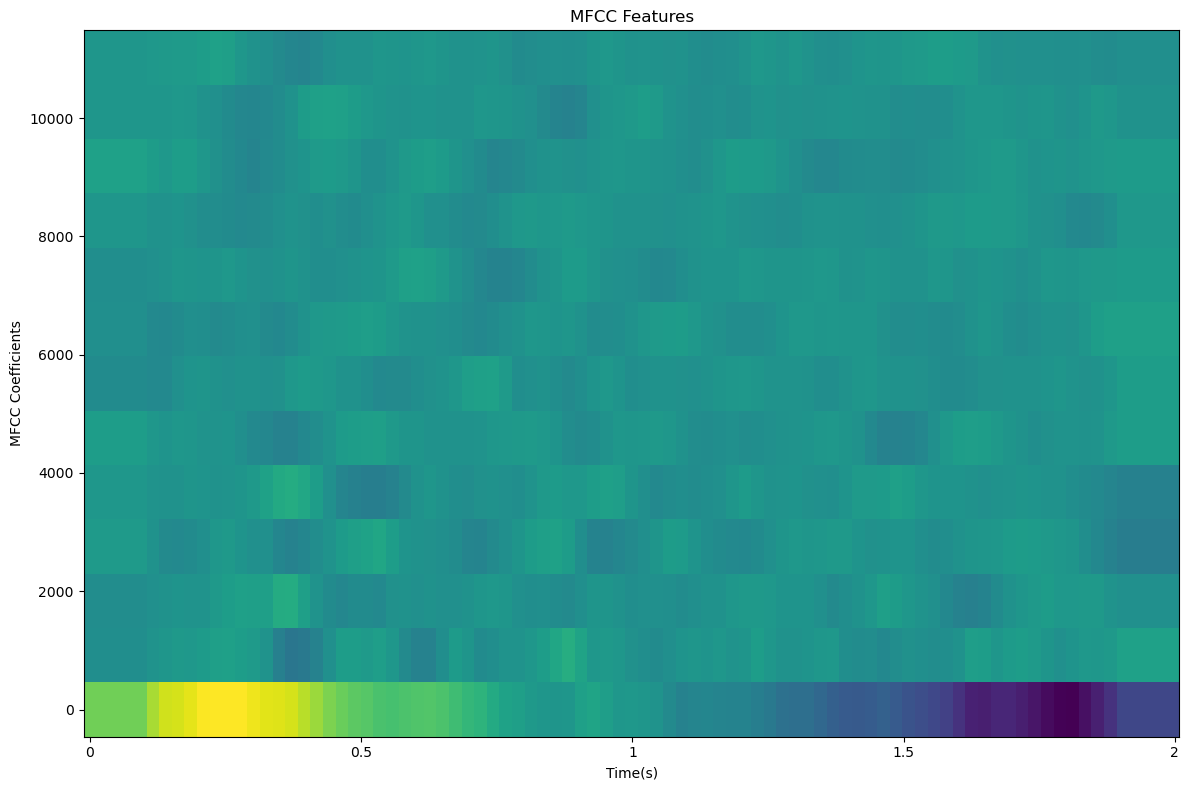

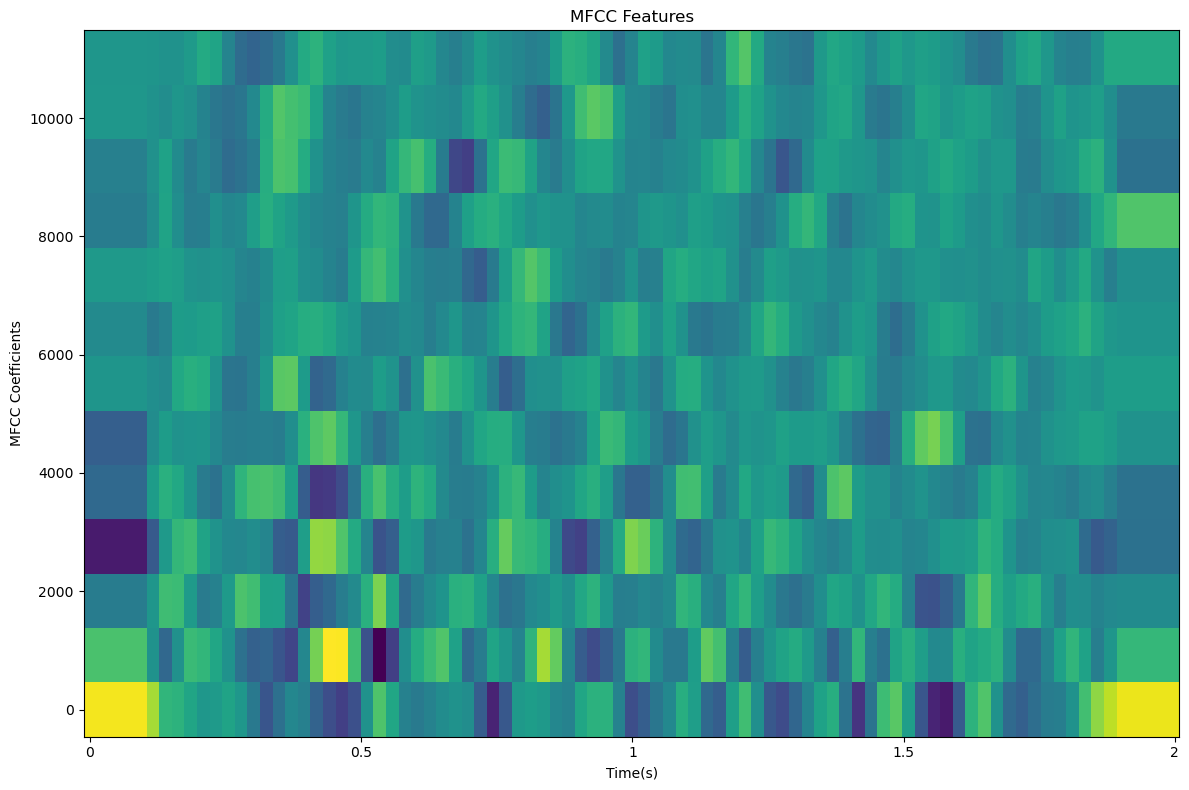

In [20]:
# 音频文件路径
audio_file = r'E:\数据集\ShipEar\data_preprocessing\3_Frame_Windows_2s_50%\6__10_07_13_marDeCangas_Entra_18.wav'

# 加载音频文件
waveform, original_sr = torchaudio.load(audio_file)

# 重采样
target_sr = 22050
if original_sr != target_sr:
    resampler = torchaudio.transforms.Resample(original_sr, target_sr)
    waveform = resampler(waveform)

# 创建MFCC变换器
mfcc_transformer = extract_mfcc_transformer(target_sr, n_mfcc=40)

# 提取MFCC特征
mfcc_features = mfcc_transformer(waveform)

# 转换为numpy数组便于处理
mfcc_data = mfcc_features.detach().cpu().numpy()[0]

# 保存MFCC特征到CSV
save_mfcc_to_csv(mfcc_data, 'mfcc_features.csv')

# 可视化MFCC特征
plot_mfcc_features(mfcc_data, target_sr, 'mfcc_features.png')
# 可视化MFCC一阶差分特征
extract_mfcc_with_delta(waveform, target_sr, feature_type='delta')
# 可视化MFCC二阶差分特征
extract_mfcc_with_delta(waveform, target_sr, feature_type='delta2')
